# Backtester for Columbia Arabesque Project


This example uses the signals output from machine learning phase to simulate results in a real trading environment with transaction costs and mananagement fees

## Step 1: download and install backtrader
if not already installed install backtrader
<font color=blue><pre>$> pip install backtrader</pre></font>

## Step 2:  Import required modules

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import pandas as pd
import datetime
import logging
import os.path
import sys

import backtrader as bt
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt
from scipy.stats import mstats

logger = logging.getLogger()

## Step 3: Define global variables to hold trade and position data...

These variables will be used to store trade PNL (PNL_DICT) and daily market value (MKT_DICT) of each position and current cash balance.  It is stored in a dictionary with the ticker as the key with an array of tuples consisting of date and value.  For the trade PNL, it is recorded when the trade is closed.

In [2]:
#global variables

# Structure to store daily values 
PNL_DICT = {}
MKT_DICT = {}


## Step 4: Define global control variables...

These variables control the execution of the program and set starting balances as described below

In [3]:
# control the output
DEBUG = True
SAVE_OUTPUT_FILES = False

# control the tickers to include
NUM_TICKERS = 1
TICKERS = None #['x189']

# winsorization percent value to clip data
WINSORIZATION_LEVEL = 1000

# initial cash balance
START_BALANCE = 1000000.0

# control whether to show Backtrader charts
SHOW_BACKTRADER_CHARTS = False

## Step 5: Create Strategy Class

This class is used to apply our machine learning algorithm to generate buy and sell orders.  In this example we already have signals generated in a separate process.  The signals in this case are a simple weighted value based on the concurrent number of buy signals for the day. The signals are are added to the openinterest column as described in **Step 10.

Backtrader, does have a Signals class that uses LONG, SHORT and other predifined signals, but using this class provided more flexibility.

This is a subclass of the Backtrader Strategy class and overrides the following methods:

### 1. next()
This method is called for each time period in the data source and access is available to all data streams

### 2. notify_order()
This method is called for each disposition of an order and can be used to analyse and control order execution 

### 3. notify_trade()
This method is called for each trade that is closed and the PNL associated with the trade can be derived.



In [4]:
class MyStrategy(bt.Strategy):
    lines = ('signal',)

    def __init__(self):
        self.lines.signal = self.data.openinterest
        self.order = None

    # this method is used to update the data dictionaries
    def updateDict(self, dict, date, ticker, value):
        if ticker in dict.keys():
            dict[ticker].append((date, value))
        else:
            dict[ticker] = [(date, value)]

    # this method is called for each date which then 
    # traversess each security to determine whether to 
    # buy, close or rebalance a position.
    def next(self):
        idx = self.datetime.idx
        dt = self.datetime.date()
        cash = self.broker.get_cash()
        
        # add cash balance to market value...
        self.updateDict(MKT_DICT, idx, 'cash', cash)
        
        # loop through each ticker
        for i, d in enumerate(self.datas):
            dn = d._name
            pos = self.getposition(d).size
            signal = d.openinterest.array[idx]
            size = 0
            if pos:
                # add market value of any positions
                self.updateDict(MKT_DICT, idx, dn, pos * d.close.array[idx])
                
                # check if position needs to be adjusted up or down
                if signal > 0:
                    prev_signal = d.openinterest.array[idx-1]
                    if signal < prev_signal:
                        # reduce the size...
                        size = int(round(pos * (1 - signal/prev_signal)))
                        if size > 10:
                            self.order = self.sell(data=d, size=size, price=d.close[0])
                    elif signal > prev_signal:
                        # increase size
                        size = int(self.sizer.getsizing(d, True) * signal)
                        if size > 10:
                            self.order = self.buy(data=d, size=size, price=d.close[0])
                else:
                    # close out the position if no signal
                    self.order = self.close(data=d)
            elif signal > 0:
                # this is new trade 
                try:
                    size = int(self.sizer.getsizing(d, True) * signal)
                    self.order = self.buy(data=d, size=size) 
                except Exception as ex:
                    logger.info('Exception trading: %s  row: %s' % (dn, idx))
                    pass

    # this method is callback for each order
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                if DEBUG:
                    logger.info('BUY EXECUTED, row: %s, Ticker: %s, Price: %.2f, Shares: %s, Cost: %.2f, Comm %.2f, Cash %.2f' %
                          (order.plen, order.data._name, order.executed.price, order.size, order.executed.value, order.executed.comm, self.broker.getcash()))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                if DEBUG:
                    logger.info('SELL EXECUTED, row %s, Ticker: %s, Price: %.2f, shares: %s, Cost: %.2f, Comm %.2f, Cash %.2f' % (
                        order.plen, order.data._name, order.executed.price, order.size, order.executed.value, order.executed.comm, self.broker.getcash()))
                    pass
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # if trade did not succeed
            message = 'name %s idx: %s size: %s  price %s  cash: %s' % (order.data._name, order.plen, order.size, order.data.close[0], self.broker.getcash())
            if order.status == order.Canceled:
                logger.info('Order Canceled: %s' % message)
            elif order.status == order.Rejected:
                logger.info('Order Rejected: %s' % message)
            elif order.status == order.Margin:
                logger.info('Order Margin exceeded: %s' % message)

        # Write down: no pending order
        self.order = None

    # this method is called when trade is completed
    # the pnl is added to the PNL dict
    def notify_trade(self, trade):
        if trade.isclosed:
            ticker = trade.getdataname()
            self.updateDict(PNL_DICT, trade.barclose, ticker, trade.pnlcomm)
        return


## Step 6: Create Sizer Class 

This class is used to to dynamically allocate the size of the trade relative to available cash.  In this example, the size is based on percentage of AUM with look ahead feature in case the next price is higher than the current price.  This obviously would not work with realtime data. 

In [5]:
class MySizer(bt.sizers.PercentSizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        self.params.percents = 95
        self.params.retint = True
        price0 = data.close[0]
        try:
            price1 = data.close[1]
        except:
            price1 = price0
        price = max(price0, price1)
        size = cash / price * (self.params.percents / 100)
        if self.p.retint:
            size = int(size)
        return size

## Step 7:  Function to Read Backtest Returns Data.
This Function reads the security return data that was used to generate the signal data for this example. 

The return data is contained in a tall table that is reformatted and converted to price data 
 * Read and pivot data
 * Perform Winsoration if enabled
 * Coumpound returns and convert to prices
 * Forward fill any missing data
 * Filter out known bad data and remove empty columns
 * Filter selected Tickers if set


In [6]:
def winsorize(df, limits=(0.01,0.01), inclusive=(False,False)):
    ## following method performs trimming the tail based on
    ## limit value percentages which is not used for this example
    def winsorizeSeries(s):
        try:
            a = s[~pd.isnull(s)].astype(float)
            s[~pd.isnull(s)] = mstats.winsorize(a, limits)
        except Exception as ex:
            pass
        return s
    
    ## df = df.apply(winsorizeSeries, axis=0)
    ## use clip Winsorization method in this example
    df = df.clip(upper=WINSORIZATION_LEVEL)
    return df

def convertReturnsToPrice(filename):
    df = pd.read_csv(filename)
    df['assetid'] = 'x' + df.assetid.astype(str)
    # to maintain same order as pivot sorts cols alphabetically
    order = df.assetid.unique()
    df = df.pivot(index='date', columns='assetid', values='value')
    df.index = pd.to_datetime(df.index)
    df = df.reindex(order, axis=1)
    if WINSORIZATION_LEVEL:
        df = winsorize(df)
    dfp = 100 + ((df + 1).cumprod() - 1) * 100
    return dfp

def getPrices(filename):
    df = convertReturnsToPrice(filename)
    # read the prices
    df = df.sort_index()
    df = df.ffill()
    # drop columns with bad prices
    droplist = ['x209', 'x291', 'x657', 'x1079', 'x2781', 'x2953', 'x3549', 'x3850', 'x4034', 'x5388',\
                'x11286','x11882', 'x12486', 'x14258', 'x18092', 'x19354', 'x19503', 'x19540','x67592',\
                'x751','x1493','x2028','x5431','x6103','x8532','x8547','x8667','x10746','x15703','x16990',\
                'x17237','x19467','x21145','x21757','x62268', 'x6240','x6217']

    for col in df.columns:
        distinct = df[col].unique()
        if len(distinct) == 1 and pd.isna(distinct[0]):
            droplist.append(col)
    if len(droplist):
        logger.info('dropping nan columns %s' % droplist)
        df = df.drop(droplist, axis=1)
    if TICKERS:
        df = df[TICKERS]
    elif NUM_TICKERS and NUM_TICKERS < len(df.columns):
        df = df[df.columns[0:NUM_TICKERS]]
    return df


## Step 8: Function to Read Signals Data 

This function reads the signals file that was generated by another process.  In this example, the signal file consists of binary values that indicate buy and hold when true and sell or ignore when false.  The signals are equally weighted based on the number of buy signals for each period.  

In [7]:
def getSignals(dfp, filename):
    #read the signals
    df = pd.read_csv(filename)
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    # reorder signal columns to match prices...
    df = df[dfp.columns]
    # shift columns up two periods...
    df = df.shift(periods=-1).ffill()
    # find any missing rows in signals data...
    missing = set(dfp.index) ^ set(df.index)
    if missing:
        # create empty dataframe
        dfm = pd.DataFrame([],index=missing, columns=df.columns)
        df = dfm.append(df)
    df = df.sort_index()
    df = df.fillna(0)
    if TICKERS:
        df = df[TICKERS]
    elif NUM_TICKERS and NUM_TICKERS < len(df.columns):
        df = df[df.columns[0:NUM_TICKERS]]
    return df


## Step 9:  Function to Compute Equal Weighted Signals...

In this function, the signal values are normalized to that of the prices that were read in the previous step.

In [8]:
def computeEqualWeightedSignals(dfs):
    sum = dfs.sum(axis=1)
    if any(sum > 1):
        dfs = dfs.div(sum, axis=0).fillna(0.0)
    return dfs


## Step 10: Function to Add Data to Cerebro

This function is used to add data to Cerebro, which is the Backtrader calculation engine.  Cerebro is designed to read a stream either from a source such as Yahoo or Google or realtime datafeed, but in this case we are loading static historical data using their dataframe interface.

As previously mentioned, the signals data is store in the "openinterest" field and the "Closing Prices" prices data is replicated for the other fields needed by Cerebro to function properly.

The price and signals data are merge with signals using openinterest and close for open, high, low.
Backtrader relies on the following data:

<font color=blue><pre>
Open
High
Low
Close
Volume
Openinterest
</pre></font>


In [9]:
def addData(cerebro, dfp, dfs):
    for idx in range(len(dfp.columns)):
        col = dfp.columns[idx]
        df = dfp[[col]].join(dfs[[col]],rsuffix='x').fillna(-1.0)
        # use close for the price and open for the signal
        df.columns = ['close', 'openinterest']
        df['open'] = df.close
        df['high'] = df.close
        df['low'] = df.close
        df['volume'] = df.close
        data = bt.feeds.PandasData(dataname=df, name=col)
        cerebro.adddata(data)
    logger.info('added %s columns' % (idx+1))

## Step 11: Function to Generate Table from Dictionary
This is post processing function to convert trade PNL and Daily Market Values to tables

In [10]:
def genTableFromDict(dfp, dict):
    df = pd.DataFrame()
    # each ticker is different lenght, so have to do one table at a time
    # use price dataframe to normalize date column
    for key in dict.keys():
        dfi = pd.DataFrame(dict[key], columns=['index', key]).set_index('index')
        df = dfi if df.empty else df.join(dfi)
    df = dfp.reset_index()[['date']].join(df).set_index('date')
    ## to preserve column order
    cols = set(dfp.columns) & set(df.columns)
    colorder = ['cash']
    colorder.extend(dfp.columns[[x in cols for x in dfp.columns]])
    df = df.reindex(columns=colorder)
    return df


## Step 12.  Function to Initialize Logger
The logger is used in this example to generation a log file, so that the trades may be examined after the run

In [11]:
def initLogger():
    root = '/tmp/marketdata/' if 'linux' in sys.platform else '../log'
    os.makedirs(root, exist_ok=True)
    fh = logging.FileHandler(os.path.join(root,'backtest-{:%Y-%m-%d-%H-%M-%S}.log'.format(datetime.datetime.now())))
    formatter = logging.Formatter('%(asctime)s | %(levelname)-8s | %(lineno)04d | %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    logger.addHandler(logging.StreamHandler())
    logger.setLevel(logging.INFO)


## Step 13: Create cerebro object
  * set initial broker cash balance
  * add strategy class
  * add sizer
  * add Analyser
  * set broker commision
  * read price data
  * read signal data
  * add data to Cerebro

In [12]:
logger.info('Starting BackTrader')

cerebro = bt.Cerebro()
cerebro.broker.setcash(START_BALANCE)
cerebro.addstrategy(MyStrategy)
cerebro.addsizer(MySizer)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.broker.setcommission(commission=0.001)
cerebro._disable_runonce()

# get daily prices
dfp = getPrices('../arabesque/DailyAssetReturns.csv')

#get signals
dfs = getSignals(dfp, '../arabesque/IEOR4576_ALLOC.csv')
dfs = computeEqualWeightedSignals(dfs)

# add data to cerebro
addData(cerebro, dfp, dfs)


## Step 14:  Run Cerebro

This step performs the exection of the backtrader and may take up to 30-40 minutes to run for the full dataset.

In [13]:
# initialize cerebro

logger.info('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# run the strategy
strats = cerebro.run()

# get the results
logger.info('Sharpe Ratio: %s' % strats[0].analyzers.mysharpe.get_analysis()['sharperatio'])
endBalance = cerebro.broker.getvalue()
logger.info('Final Portfolio Value: %.2f' % endBalance)



## Step 15: Perform Post Processing of Trade Data

If the trade data is saved, analysis of the results may be performed in a separate process.  Change the file names between runs, or the files will be over written with the latest run 

In [14]:
# get the market values from the strategy 
# and convert to dataframe and savedft = genTableFromDict(dfp, PNL_DICT)
dfc = genTableFromDict(dfp, MKT_DICT)
dft = genTableFromDict(dfp, PNL_DICT)

if SAVE_OUTPUT_FILES:
    dft.to_csv('../arabesque/backtest-trade-pnl.csv')
    dfc.to_csv('../arabesque/backtest-daily-pnl.csv')
    

## Step 16: Compute Benchmark Returns by Aggregating Asset Returns

The benchmark data is merged with the aggregated trade data (called "strat") which consists of the sum of the cash and position balances for each period

In [15]:
dfc['strat'] = dfc.fillna(0.0).sum(axis=1)
dfx = dfp.pct_change()
# compute row weights to filter NAN values per row
w = dfx.apply(lambda x: x.count(), axis=1)
dfr = pd.DataFrame(dfx.div(w, axis=0).sum(axis=1), columns=['benchmark'])
dfr = START_BALANCE + ((dfr + 1).cumprod() - 1) * START_BALANCE
df = dfr.join(dfc[['strat']]).ffill()

## Step 17: Plot the Data

This step will plot the above data showing the strategy, **strat** performance relative to buying each stock in the portfolio, **benchmark**

Note uncomment %matlab below to show the chart as a separate window. 

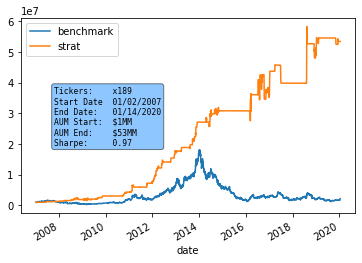

In [16]:
if not SHOW_BACKTRADER_CHARTS:
    # %matplotlib

    ax = df.plot(kind='line')
    df.head()
    # add stats...
    tickers = TICKERS if TICKERS else dfp.columns[0:NUM_TICKERS] if NUM_TICKERS else dfp.columns
    tickers = ', '.join(tickers) if len(tickers) <= 5 else '%s - %s' % (tickers[0], tickers[-1])

    textstr = '\n'.join((
        'Tickers:    %s' % tickers,
        'Start Date  %s' % dfp.index[0].strftime('%m/%d/%Y'), 
        'End Date:   %s' % dfp.index[-1].strftime('%m/%d/%Y'),
        'AUM Start:  $%.0fMM' % (START_BALANCE/1E6),
        'AUM End:    $%.0fMM' % (endBalance/1E6),
        'Sharpe:     %.2f' % strats[0].analyzers.mysharpe.get_analysis()['sharperatio']))

    props = dict(boxstyle='round', facecolor='dodgerblue', alpha=0.5)
    ax.text(0.1, 0.65, textstr, transform=ax.transAxes, family='monospace', fontsize=8, verticalalignment='top', bbox=props)
    ax.get_legend().remove()
    plt.legend(loc='upper left')
    plt.show()


## Step 18:  Show Backtrader Charts

Backtrader has built in charting capability that shows the start and end and PNL for each trade and net value.  A separate chart is shown for each ticker, so running more than four tickers at once will make the charts incomprehensible. 

Note that the Backtrader charts cannot be shown if the above chart is present, so must choose one or the other.

In [17]:
if SHOW_BACKTRADER_CHARTS:
    pkwargs = dict(style='bar')
    cerebro.plot(**pkwargs)